In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pandas
import pynumdiff
import scipy.fftpack
from IPython.display import display,SVG
import figurefirst
fifi = figurefirst

import copy

In [124]:
import run_pareto_plot

In [140]:
def get_gamma(dt, freq, timeseries_length=None):
    try:
        if dt == 0.1:
            log_g = np.log(freq)*(-1.5) -4
        if dt == 0.01:
            log_g = np.log(freq)*(-1.5) -1.8
        if dt == 0.001:
            log_g = np.log(freq)*(-1.5) -0.5
            
        return np.exp(log_g)
    
    except:
        log_gs = []
        for f in freq:
            if dt == 0.1:
                log_gs.append(np.log(freq)*(-1.5) -4) 
            if dt == 0.01:
                log_gs.append(np.log(freq)*(-1.5) -1.8) 
            if dt == 0.001:
                log_gs.append(np.log(freq)*(-1.5) -0.5) 
            
        return np.exp(np.array(log_gs))
            


In [141]:
def load_data(fname):
    f = open(fname, 'rb')
    data = pickle.load(f)
    f.close()
    return data

In [142]:
def get_goldilocks_gamma(data):
    rmses = data['rmses_gamma']
    errcorrs = data['errcorrs_gamma']

    threshold = 0.25
    while len(np.where(errcorrs<threshold)[0]) < 1:
        threshold += 0.05
        
    idx_errcorr_okay = np.where(errcorrs<threshold)

    idx_opt =  idx_errcorr_okay[0][np.argmin(rmses[idx_errcorr_okay])]

    opt_rmse = rmses[idx_opt]
    opt_errcorr = errcorrs[idx_opt]
    
    return data['metadata']['gammas'][idx_opt], opt_rmse, opt_errcorr, idx_opt

def plot_direct_goldilocks_gamma(ax, data, color):
    goldgamma, opt_rmse, opt_errcorr, idx_opt = get_goldilocks_gamma(data)

    print('goldilocks gamma: ', goldgamma)
    print('goldilocks rmse and errcorr: ', opt_rmse, opt_errcorr)
    print('opt params: ', data['metadata']['params'][idx_opt])
    
    ax.plot(opt_rmse, opt_errcorr, '*', color=color, markersize=20, markeredgecolor='black')
    
    #ax.set_xlim(1e-1, 1e2)

In [143]:
def plot_xdots(ax, data, x, dxdt_truth, t, color):
    idx_best = np.argmin(data['rmses'])
    params = run_pareto_plot.get_params_for_method('savgoldiff', 'linear_model')
    print('best params: ', params[idx_best])
    x_hat, xdot_hat = pynumdiff.linear_model.savgoldiff(x, dt, params[idx_best])
    ax.plot(t, xdot_hat, color='gray', linewidth=4, zorder=-10, alpha=0.5)
    
    
    goldgamma, _, _, goldidx = get_goldilocks_gamma(data)
    params = data['metadata']['params']
    print('goldilocks gamma params: ', params[goldidx])
    x_hat, xdot_hat = pynumdiff.linear_model.savgoldiff(x, dt, params[goldidx])
    ax.plot(t, xdot_hat, color=color, linewidth=1, zorder=-5)
    
    ax.plot(t, dxdt_truth, '--', color='black', zorder=-1, linewidth=0.5)
    
    ax.set_rasterization_zorder(0)

In [129]:
def plot_example(example, x, x_truth, dxdt_truth, t, color, data, xlimits, ylimits, xticks, yticks):
    layout = fifi.svg_to_axes.FigureLayout(figure_layout, autogenlayers=True, 
                                       make_mplfigures=True, hide_layers=[])

    
    ax_pareto = layout.axes[(example, 'pareto')]
    ax_pos = layout.axes[(example, 'sine')]
    ax_vel = layout.axes[(example, 'vel')]
    
    ax_pos.plot(t, x, '.', color='blue', zorder=-10, markersize=2)
    ax_pos.set_rasterization_zorder(0)
    ax_pos.plot(t, x_truth, '--', color='black', linewidth=0.5)
    
    plot_xdots(ax_vel, data, x, dxdt_truth, t, color)
    
    ax_pareto.plot((data['rmses']), data['errcorrs'], '.', color='gray', zorder=-10, markersize=2)
    try:
        ax_pareto.set_rasterization_zorder(0)
    except:
        print('could not rasterize')
        
    ax_pareto.plot((data['rmses_gamma']), data['errcorrs_gamma'], '.', color=color, zorder=1, markersize=2)
    ax_pareto.plot((data['rmses_gamma']), data['errcorrs_gamma'], '-', color=color)
    plot_direct_goldilocks_gamma(ax_pareto, data, color)
    
    ax_pos.set_xlim(xlimits['pos'][0], xlimits['pos'][-1])
    ax_pos.set_ylim(ylimits['pos'][0], ylimits['pos'][-1])
    
    ax_vel.set_xlim(xlimits['vel'][0], xlimits['vel'][-1])
    ax_vel.set_ylim(ylimits['vel'][0], ylimits['vel'][-1])
    
    if example == 'freq_1':
        fifi.mpl_functions.adjust_spines(ax_pos, ['left'], 
                                     xticks=xticks['pos'], 
                                     yticks=yticks['pos'],
                                     tick_length=2.5,
                                     spine_locations={'left': 4, 'bottom': 4})
        fifi.mpl_functions.adjust_spines(ax_vel, ['left', 'bottom'], 
                                     xticks=xticks['vel'], 
                                     yticks=yticks['vel'],
                                     tick_length=2.5,
                                     spine_locations={'left': 4, 'bottom': 4})
    else:
        fifi.mpl_functions.adjust_spines(ax_pos, ['left'], 
                                     xticks=xticks['pos'],
                                     yticks=yticks['pos'],
                                     tick_length=2.5,
                                     spine_locations={'left': 4, 'bottom': 4})
        fifi.mpl_functions.adjust_spines(ax_vel, ['left', 'bottom'], 
                                     xticks=xticks['vel'], 
                                     yticks=yticks['vel'],
                                     tick_length=2.5,
                                     spine_locations={'left': 4, 'bottom': 4})
        
    exp = int(np.log10(yticks['vel'][-1]))
    ax_vel.set_yticklabels(['$-10^{'+str(exp)+'}$', '$0$', '$10^{'+str(exp)+'}$'])
        
    ax_pareto.set_xscale('log')
    ax_pareto.minorticks_off()
    ax_pareto.set_xlim(xlimits['pareto'][0], xlimits['pareto'][1])
    ax_pareto.set_ylim(ylimits['pareto'][0], ylimits['pareto'][1])
    
    if example == 'freq_1':
        fifi.mpl_functions.adjust_spines(ax_pareto, ['left', 'bottom'], 
                                         xticks=xticks['pareto'], 
                                         yticks=yticks['pareto'],
                                         tick_length=2.5,
                                         spine_locations={'left': 4, 'bottom': 4})
    else:
        fifi.mpl_functions.adjust_spines(ax_pareto, ['bottom'], 
                                         xticks=xticks['pareto'], 
                                         tick_length=2.5,
                                         spine_locations={'bottom': 4})
    
    fifi.mpl_functions.set_fontsize(ax_pareto, 6)

    layout.append_figure_to_layer(layout.figures[example], example, cleartarget=True)
    layout.write_svg(figure_layout)

In [130]:
figure_layout = 'fig_2.svg'

done simulating
pareto_specific_sine_freq_data_varpadding/pareto_data_savgoldiff_linear_model_sine_1_0.5_0.01_4_auto.pickle
best params:  [8, 177, 4]
goldilocks gamma params:  [10, 32, 33]
goldilocks gamma:  0.08858667904100838
goldilocks rmse and errcorr:  1.4015676863716802 0.08347298277381841
opt params:  [10, 32, 33]


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Better RMSE than % randos: 88.12260536398468%
Better Err Corr than % randos: 75.27823389892355%


/home/caveman/BMD2/lib/python3.5/site-packages/matplotlib-2.2.2-py3.5-linux-x86_64.egg/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


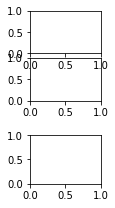

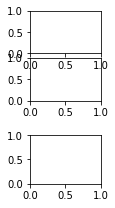

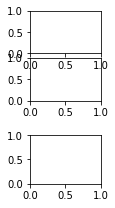

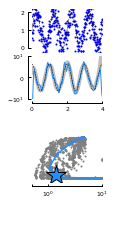

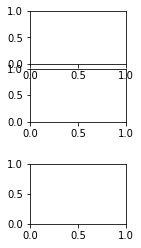

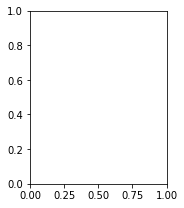

In [131]:
# define problem
example = 'freq_2'
dt = 0.01
noise = 0.5
timeseries_length = 4
problem = 'sine'
freq = 1

if timeseries_length < np.pi/freq:
    raise ValueError()
if dt > 1/freq/2.:
    raise ValueError()
    
read_existing = True
simdt = 0.0001
color = 'dodgerblue'



# define method
method_parent = 'linear_model'
method = 'savgoldiff'

# define limits
xlimits = {'pos': [0,4],
           'vel': [0,4],
           'pareto': [5e-1, 1e1]}
ylimits = {'pos': [-0.2,2.2],
           'vel': [-10, 10],
           'pareto': [-.1, 1.1]}

xticks = { 'pos': [0,2,4],
           'vel': [0,2,4],
           'pareto': [5e-1, 1e0, 1e1]}

yticks = { 'pos': [0, 1, 2],
           'vel': [-10, 0, 10],
           'pareto': [0, 1]}

r = pynumdiff.utils.simulate.sine(timeseries_length=timeseries_length, 
                                  noise_parameters=[0, noise], 
                                  dt=dt, 
                                  frequencies=[freq])

x, x_truth, dxdt_truth, _ = r
t = np.arange(0, timeseries_length, dt)
print('done simulating')
padding = 'auto'

fname = run_pareto_plot.run_pareto_analysis_on_specific_sine(noise, dt, timeseries_length, problem, freq, method, method_parent, simdt=simdt, read_existing=read_existing, num_gammas=40, padding=padding)
print(fname)
data = load_data(fname)

plot_example(example, x, x_truth, dxdt_truth, t, color, data, xlimits, ylimits, xticks, yticks) #0.0001_0.1_0.01_4_1

freq_1_gg, opt_rmse, opt_errcorr, opt_idx = get_goldilocks_gamma(data)
freq_1 = copy.copy(freq)
freq_1_color = copy.copy(color)

print('Better RMSE than % randos: ' + str(len(np.where( (opt_rmse<data['rmses']) )[0]) / len(data['rmses']) * 100) + '%')
print('Better Err Corr than % randos: ' + str(len(np.where( (opt_errcorr<data['errcorrs']) )[0]) / len(data['errcorrs']) * 100) + '%')

done simulating
pareto_specific_sine_freq_data_varpadding/pareto_data_savgoldiff_linear_model_sine_10_0.1_0.001_0.5_auto.pickle
best params:  [8, 143, 2]
goldilocks gamma params:  [3, 32, 16]
goldilocks gamma:  0.033598182862837875
goldilocks rmse and errcorr:  3.977439911554012 0.05500761613603217
opt params:  [3, 32, 16]


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/matplotlib-2.2.2-py3.5-linux-x86_64.egg/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


Better RMSE than % randos: 94.92793285896735%
Better Err Corr than % randos: 83.37894544791097%


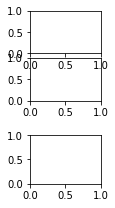

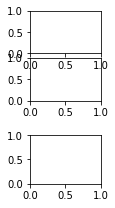

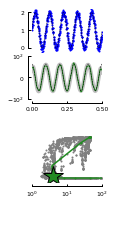

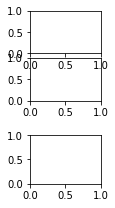

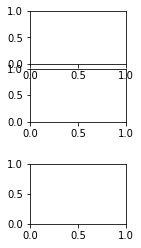

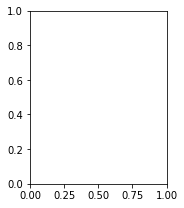

In [119]:
# define problem
example = 'freq_3'
dt = 0.001
noise = 0.1
timeseries_length = 0.5
problem = 'sine'
freq = 10


if timeseries_length < np.pi/freq:
    raise ValueError()
if dt > 1/freq/2.:
    raise ValueError()
    
read_existing = True
simdt = 0.0001
color = 'forestgreen'

# define method
method_parent = 'linear_model'
method = 'savgoldiff'

# define limits
xlimits = {'pos': [0,0.5],
           'vel': [0,0.5],
           'pareto': [0, 1e2]}
ylimits = {'pos': [-0.2,2.2],
           'vel': [-100, 100],
           'pareto': [-.1, 1.1]}

xticks = { 'pos': [0,.25, 0.5],
           'vel': [0,.25, 0.5],
           'pareto': [1e0, 1e1, 1e2]}

yticks = { 'pos': [0, 1, 2],
           'vel': [-100, 0, 100],
           'pareto': [0, 1]}

r = pynumdiff.utils.simulate.sine(timeseries_length=timeseries_length, 
                                  noise_parameters=[0, noise], 
                                  dt=dt, 
                                  frequencies=[freq])

x, x_truth, dxdt_truth, _ = r
t = np.arange(0, timeseries_length, dt)
print('done simulating')
padding = 'auto'

fname = run_pareto_plot.run_pareto_analysis_on_specific_sine(noise, dt, timeseries_length, problem, freq, method, method_parent, simdt=simdt, read_existing=read_existing, num_gammas=40, padding=padding)
print(fname)
data = load_data(fname)

plot_example(example, x, x_truth, dxdt_truth, t, color, data, xlimits, ylimits, xticks, yticks)

freq_2_gg, opt_rmse, opt_errcorr, opt_idx = get_goldilocks_gamma(data)
freq_2 = copy.copy(freq)
freq_2_color = copy.copy(color)

print('Better RMSE than % randos: ' + str(len(np.where( (opt_rmse<data['rmses']) )[0]) / len(data['rmses']) * 100) + '%')
print('Better Err Corr than % randos: ' + str(len(np.where( (opt_errcorr<data['errcorrs']) )[0]) / len(data['errcorrs']) * 100) + '%')

done simulating
pareto_specific_sine_freq_data_varpadding/pareto_data_savgoldiff_linear_model_sine_0.01_0.1_0.1_100_auto.pickle
best params:  [5, 805, 31]
goldilocks gamma params:  [1, 120, 55]
goldilocks gamma:  78.47599703514625
goldilocks rmse and errcorr:  0.003328879786912185 0.1471563328130401
opt params:  [1, 120, 55]


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Better RMSE than % randos: 88.94362342638205%
Better Err Corr than % randos: 43.56869184455391%


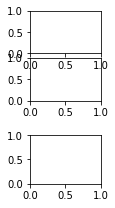

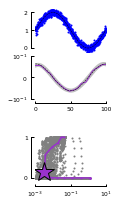

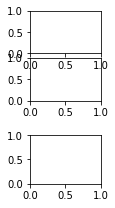

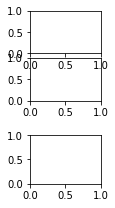

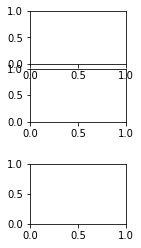

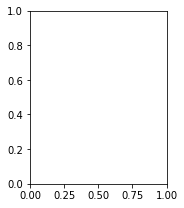

In [120]:
# define problem
example = 'freq_1'
dt = 0.1
noise = 0.1
timeseries_length = 100
problem = 'sine'
freq = 0.01


if timeseries_length < 1/freq:
    raise ValueError()
if dt > 1/freq/2.:
    raise ValueError()
    
read_existing = True
simdt = 0.0001
color = 'darkorchid'

# define method
method_parent = 'linear_model'
method = 'savgoldiff'

# define limits
xlimits = {'pos': [0,100],
           'vel': [0,100],
           'pareto': [1e-3, 1e1]}
ylimits = {'pos': [-0.2,2.2],
           'vel': [-.1, .1],
           'pareto': [-.1, 1.1]}

xticks = { 'pos': [0, 50, 100],
           'vel': [0, 50, 100],
           'pareto': [1e-3, 1e-1, 1e1]}

yticks = { 'pos': [0, 1, 2],
           'vel': [-0.1, 0, 0.1],
           'pareto': [0, 1]}

r = pynumdiff.utils.simulate.sine(timeseries_length=timeseries_length, 
                                  noise_parameters=[0, noise], 
                                  dt=dt, 
                                  frequencies=[freq])

x, x_truth, dxdt_truth, _ = r
t = np.arange(0, timeseries_length, dt)
print('done simulating')
padding = 'auto'

fname = run_pareto_plot.run_pareto_analysis_on_specific_sine(noise, dt, timeseries_length, problem, freq, method, method_parent, simdt=simdt, read_existing=read_existing, num_gammas=40, padding=padding)
print(fname)
data = load_data(fname)

plot_example(example, x, x_truth, dxdt_truth, t, color, data, xlimits, ylimits, xticks, yticks)

freq_3_gg, opt_rmse, opt_errcorr, opt_idx = get_goldilocks_gamma(data)
freq_3 = copy.copy(freq)
freq_3_color = copy.copy(color)

print('Better RMSE than % randos: ' + str(len(np.where( (opt_rmse<data['rmses']) )[0]) / len(data['rmses']) * 100) + '%')
print('Better Err Corr than % randos: ' + str(len(np.where( (opt_errcorr<data['errcorrs']) )[0]) / len(data['errcorrs']) * 100) + '%')

done simulating
pareto_specific_sine_freq_data_varpadding/pareto_data_savgoldiff_linear_model_sine_100_0.1_0.001_0.05_auto.pickle
best params:  [7, 16, 3]
goldilocks gamma params:  [9, 13, 3]
goldilocks gamma:  0.0018329807108324375
goldilocks rmse and errcorr:  90.40117359692111 0.00475724191375546
opt params:  [9, 13, 3]


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Better RMSE than % randos: 97.11731435869368%
Better Err Corr than % randos: 99.41616493340632%


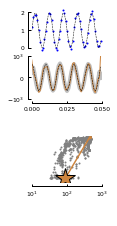

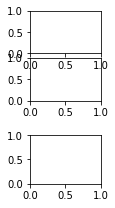

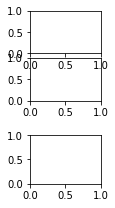

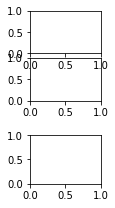

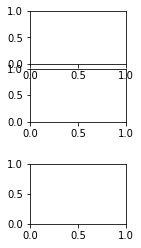

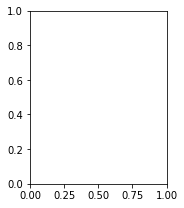

In [121]:
# define problem
example = 'freq_4'
noise = 0.1
dt = 0.001
timeseries_length = 0.05
problem = 'sine'
freq = 100


if timeseries_length < np.pi/freq:
    raise ValueError()
if dt > 1/freq/2.:
    raise ValueError()
    
read_existing = True
simdt = 0.0001
color = 'peru'

# define method
method_parent = 'linear_model'
method = 'savgoldiff'

# define method
xlimits = {'pos': [0,0.05],
           'vel': [0,0.05],
           'pareto': [1e1, 1e3]}
ylimits = {'pos': [-0.2,2.2],
           'vel': [-1000, 1000],
           'pareto': [-.1, 1.1]}

xticks = { 'pos': [0, 0.025, 0.05],
           'vel': [0, 0.025, 0.05],
           'pareto': [1e1, 1e2, 1e3]}

yticks = { 'pos': [0, 1, 2],
           'vel': [-1000, 0, 1000],
           'pareto': [0, 1]}

r = pynumdiff.utils.simulate.sine(timeseries_length=timeseries_length, 
                                  noise_parameters=[0, noise], 
                                  dt=dt, 
                                  frequencies=[freq])
x, x_truth, dxdt_truth, _ = r
t = np.arange(0, timeseries_length, dt)
print('done simulating')
padding = 'auto'

fname = run_pareto_plot.run_pareto_analysis_on_specific_sine(noise, dt, timeseries_length, problem, freq, method, method_parent, simdt=simdt, read_existing=read_existing, num_gammas=40, padding=padding)
print(fname)
data = load_data(fname)

plot_example(example, x, x_truth, dxdt_truth, t, color, data, xlimits, ylimits, xticks, yticks)

freq_4_gg, opt_rmse, opt_errcorr, opt_idx = get_goldilocks_gamma(data)
freq_4 = copy.copy(freq)
freq_4_color = copy.copy(color)

print('Better RMSE than % randos: ' + str(len(np.where( (opt_rmse<data['rmses']) )[0]) / len(data['rmses']) * 100) + '%')
print('Better Err Corr than % randos: ' + str(len(np.where( (opt_errcorr<data['errcorrs']) )[0]) / len(data['errcorrs']) * 100) + '%')

In [122]:
# make freq plots

In [79]:
def get_filenames(path, contains, does_not_contain=['~', '.pyc']):
    cmd = 'ls ' + '"' + path + '"'
    ls = os.popen(cmd).read()
    all_filelist = ls.split('\n')
    try:
        all_filelist.remove('')
    except:
        pass
    filelist = []
    for i, filename in enumerate(all_filelist):
        if contains in filename:
            fileok = True
            for nc in does_not_contain:
                if nc in filename:
                    fileok = False
            if fileok:
                filelist.append( os.path.join(path, filename) )
    return filelist

In [80]:
def get_freq_dt_noise_for_files(dirname, method, method_parent):
    filenames = get_filenames(dirname, method)
    freqs = []
    dt = []
    noises = []
    fnames = []
    paddings = []
    timeseries_length = []
    goldgammas = []
    
    for fname in filenames:
        data = load_data(fname)
        if method == data['metadata']['method']:
            if method_parent == data['metadata']['method_parent']:
                try:
                    freqs.append(data['metadata']['freq'])
                except:
                    freqs.append(None)
                dt.append(data['metadata']['dt'])
                noises.append(data['metadata']['noise'])
                fnames.append(fname)
                paddings.append(data['metadata']['padding'])
                timeseries_length.append(data['metadata']['timeseries_length'])
                goldgammas.append(get_goldilocks_gamma(data)[0])
                
        
    df = pandas.DataFrame({'freq': freqs,
                           'dt': dt,
                           'noise': noises,
                           'fname': fnames,
                           'padding': paddings,
                           'timeseries_length': timeseries_length,
                           'goldgammas': goldgammas})
    return df

In [132]:
dirname = 'pareto_sine_freq_data_varpadding'
method = 'savgoldiff'
method_parent = 'linear_model'
df = get_freq_dt_noise_for_files(dirname, method, method_parent)

In [163]:
df.timeseries_length.unique() 

array([   4,  100, 1000,  500,   25,    1,    5])

In [149]:
def plot_gamma_vs_freq(ax, df, color, marker):
    dfq = df[df.timeseries_length >= 1/df.freq]
    dfq = dfq[dfq.dt <= 1/dfq.freq/2.]
    print(len(dfq))
          
    ax.plot(dfq.freq.values + np.random.uniform(-.5, 0.5, len(dfq.freq.values))*np.abs(dfq.freq.values), 
            dfq.goldgammas.values + np.random.uniform(-0.5, 0.5, len(dfq.freq.values))*np.abs(dfq.goldgammas.values), 
            marker, color=color)
    
    dfq = df[df.timeseries_length < 1/df.freq]    
    ax.plot(dfq.freq.values + np.random.uniform(-.5, 0.5, len(dfq.freq.values))*np.abs(dfq.freq.values), 
            dfq.goldgammas.values + np.random.uniform(-0.5, 0.5, len(dfq.freq.values))*np.abs(dfq.goldgammas.values), 
            '+', color=color)
    
    #dfq = dfq[dfq.dt > 1/dfq.freq/2.]
    #ax.plot(dfq.freq.values + np.random.uniform(-.5, 0.5, len(dfq.freq.values))*np.abs(dfq.freq.values), 
    #        dfq.goldgammas.values + np.random.uniform(-0.5, 0.5, len(dfq.freq.values))*np.abs(dfq.goldgammas.values), 
    #        '+', color=color)

46
38
29


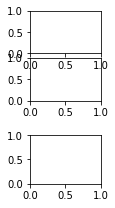

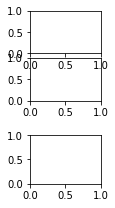

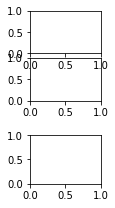

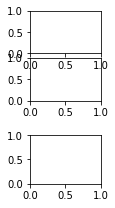

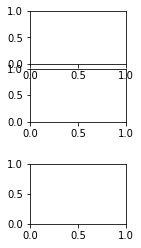

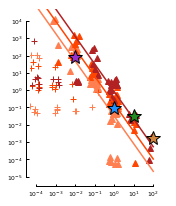

In [211]:
layout = fifi.svg_to_axes.FigureLayout(figure_layout, autogenlayers=True, 
                                   make_mplfigures=True, hide_layers=[])

ax4 = layout.axes[('gamma_vs_freq_4', 'gamma_vs_freq')]

df_dt1 = df.query('dt == 0.1')
plot_gamma_vs_freq(ax4, df_dt1, "coral", "^")
#plot_gamma_vs_freq(ax4, df_dt1[df_dt1.timeseries_length >= 1/df_dt1.freq], "coral", "s")

df_dt01 = df.query('dt == 0.01')
plot_gamma_vs_freq(ax4, df_dt01, "orangered", "^")
#plot_gamma_vs_freq(ax4, df_dt01[df_dt01.timeseries_length >= 1/df_dt01.freq], "orangered", "s")

df_dt001 = df.query('dt == 0.001')
plot_gamma_vs_freq(ax4, df_dt001, "firebrick", "^")
#plot_gamma_vs_freq(ax4, df_dt001[df_dt001.timeseries_length >= 1/df_dt001.freq], "firebrick", "s")


# empirical relationship
freqs = np.logspace(-4, 2)
gg = get_gamma(0.1, freqs)
gg = np.exp(-0.71*np.log(0.1) -1.59*np.log(freqs) -5.1)
ax4.plot(freqs, gg, color='coral')

freqs = np.logspace(-4, 2)
gg = get_gamma(0.01, freqs)
gg = np.exp(-0.71*np.log(0.01) -1.59*np.log(freqs) -5.1)
ax4.plot(freqs, gg, color='orangered')

freqs = np.logspace(-4, 2)
gg = get_gamma(0.001, freqs)
gg = np.exp(-0.71*np.log(0.001) -1.59*np.log(freqs) -5.1)
ax4.plot(freqs, gg, color='firebrick')


# plot stars
try:
    ax4.plot(freq_1, freq_1_gg, '*', color=freq_1_color, markersize=15, markeredgecolor='black')
    ax4.plot(freq_2, freq_2_gg, '*', color=freq_2_color, markersize=15, markeredgecolor='black')
    ax4.plot(freq_3, freq_3_gg, '*', color=freq_3_color, markersize=15, markeredgecolor='black')
    ax4.plot(freq_4, freq_4_gg, '*', color=freq_4_color, markersize=15, markeredgecolor='black')
except:
    pass

for ax in [ax4]:
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_ylim(5e-6,5e4)
    ax.set_xlim(5e-5,5e2)

    ax.minorticks_off()

    fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 tick_length=2.5,
                                 xticks = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                                 yticks = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3, 1e4],
                                 spine_locations={'left': 4, 'bottom': 4})


    fifi.mpl_functions.set_fontsize(ax, 6)

layout.append_figure_to_layer(layout.figures['gamma_vs_freq_4'], 'gamma_vs_freq_4', cleartarget=True)
layout.write_svg(figure_layout)

In [135]:
def get_correlation(df):
    dfq = df[df.timeseries_length >= 1/df.freq]
    dfq = dfq[dfq.dt <= 1/dfq.freq/2.]
    return scipy.stats.linregress(np.log(dfq.freq), np.log(dfq.goldgammas) )

In [136]:
get_correlation(df)

LinregressResult(slope=-1.4299267862827156, intercept=-1.845128629576643, rvalue=-0.8195867636466607, pvalue=1.3008626700197654e-28, stderr=0.09488071733709989)

In [137]:
df_dt01 = df.query('dt == 0.1')
get_correlation(df_dt01)

LinregressResult(slope=-2.0081307467736202, intercept=-4.405010951416615, rvalue=-0.9029212347534962, pvalue=9.637689148795385e-18, stderr=0.1441080723278107)

In [138]:
df_dt01 = df.query('dt == 0.01')
get_correlation(df_dt01)

LinregressResult(slope=-1.4780571607059185, intercept=-1.331996749094163, rvalue=-0.9195466642492454, pvalue=3.568653359372674e-16, stderr=0.10527798669400695)

In [139]:
df_dt01 = df.query('dt == 0.001 ')
get_correlation(df_dt01)

LinregressResult(slope=-1.1650011103708622, intercept=-0.2607857866815348, rvalue=-0.8417038952655274, pvalue=1.0578445480471267e-08, stderr=0.1438235941500216)

In [165]:
df.columns

Index(['dt', 'fname', 'freq', 'goldgammas', 'noise', 'padding',
       'timeseries_length'],
      dtype='object')

In [209]:
import statsmodels.formula.api as smf
def show_ols(df, formula):
    dfq = df[df.timeseries_length >= 1/df.freq]
    dfq = dfq[dfq.dt <= 1/dfq.freq/2.]
    #dfq = dfq[dfq.dt == 0.001]
    
    logdfq_dict = {}
    for col in dfq.columns:
        if col == 'padding' or col == 'fname':
            logdfq_dict[col] = dfq[col]
        else:
            logdfq_dict[col] = np.log(dfq[col])
    logdfq = pandas.DataFrame(logdfq_dict)
    
    est = smf.ols(formula=formula, data=logdfq).fit()
    return est

In [210]:
formula = 'goldgammas ~ freq + dt + noise + timeseries_length'
est = show_ols(df, formula)
est.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:               OLS              Adj. R-squared:     0.761   
Dependent Variable:  goldgammas       AIC:                485.8970
Date:                2020-05-18 15:44 BIC:                499.5339
No. Observations:    113              Log-Likelihood:     -237.95 
Df Model:            4                F-statistic:        90.15   
Df Residuals:        108              Prob (F-statistic): 1.63e-33
R-squared:           0.770            Scale:              4.1324  
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept         -5.5088   0.7715  -7.1401 0.0000 -7.0382 -3.9795
freq              -1.5085   0.1069 -14.1064 0.0000 -1.7204 -1.2965
dt                -0.7542   0.1119  -6.7368 0.0000 -0.9761 -0.5323
noise              0.0760   0.1217   0.6241 0.5339 -0.1653  0.3172
timeseries_length  0.1502   0.1210   1.2413 0.2172 -0.0896  0.3900
------------------------------------------------------------------
Omnibus:              52.234       Durbin-Watson:          1.446  
Prob(Omnibus):        0.000        Jarque-Bera (JB):       115.598
Skew:                 -1.940       Prob(JB):               0.000  
Kurtosis:             6.081        Condition No.:          27     
==================================================================

"""

In [197]:
formula = 'goldgammas ~ freq + dt'
est = show_ols(df, formula)
est.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.761   
Dependent Variable: goldgammas       AIC:                483.8101
Date:               2020-05-18 15:23 BIC:                491.9922
No. Observations:   113              Log-Likelihood:     -238.91 
Df Model:           2                F-statistic:        179.6   
Df Residuals:       110              Prob (F-statistic): 2.24e-35
R-squared:          0.766            Scale:              4.1265  
------------------------------------------------------------------
              Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept    -5.1041    0.5367   -9.5106  0.0000  -6.1677  -4.0405
freq         -1.5895    0.0841  -18.9105  0.0000  -1.7561  -1.4229
dt           -0.7179    0.1082   -6.6365  0.0000  -0.9323  -0.5035
-----------------------------------------------------------------
Omnibus:             54.953       Durbin-Watson:          1.455  
Prob(Omnibus):       0.000        Jarque-Bera (JB):       126.717
Skew:                -2.029       Prob(JB):               0.000  
Kurtosis:            6.233        Condition No.:          14     
=================================================================

"""